# Szyfrowanie w pełni holomorficzne - Laboratorium 02

## Zadanie 1.

Skopiuj kod pierścienia $\mathbb{Z}_{17}[X]/(X^4+1)$ wraz z arytmetyką oraz kod uproszczonej wersji algorytmu BGV z poprzednich zajęć - przydadzą się.

In [552]:
import numpy as np
import random
from math import log2, floor
import matplotlib.pyplot as plt

In [28]:
class Ring_4_17:
    def __init__(self):
        self.q = 17
        self.w = np.poly1d([1, 0, 0, 0, 1])
        
    def ring_rep(self, poly):
        return np.poly1d(np.floor(np.polydiv(poly, self.w)[1]) % self.q)
    
    def add_poly(self, poly_1, poly_2):
        return np.poly1d(np.floor(np.polyadd(poly_1, poly_2)) % self.q)

    def sub_poly(self, poly_1, poly_2):
        return np.poly1d(np.floor(np.polysub(poly_1, poly_2)) % self.q)
    
    def mul_poly(self, poly_1, poly_2):
        return np.poly1d(np.floor(np.polydiv(np.polymul(poly_1, poly_2), self.w)[1]) % self.q)

    def mul_poly_int_right(self, poly, num):
        return np.poly1d(np.floor(np.polydiv(np.polymul(poly, np.poly1d([num])), self.w)[1]) % self.q)

    def mul_poly_int_left(self, num, poly):
        return np.poly1d(np.floor(np.polydiv(np.polymul(np.poly1d([num]), poly), self.w)[1]) % self.q)

In [29]:
class BGV:
    def __init__(self, n, q, t):
        self.n = n
        self.q = q
        self.t = t
        self.ring = Ring_4_17()
    
    def secret_key_gen(self):
        return np.poly1d(np.random.binomial(1, 0.2, self.n - 2))
    
    def pub_key_gen(self, sk, max_coeff = 100):                     
        a = self.ring.ring_rep(np.poly1d(np.random.randint(-max_coeff, max_coeff, self.n)))
        e = self.ring.ring_rep(np.poly1d(np.random.randint(0, 3, self.n - 2)))
        pk0 = self.ring.add_poly(self.ring.mul_poly(a, sk), self.ring.mul_poly_int_left(self.t, e))
        pk1 = self.ring.mul_poly_int_left(-1, a)
        return pk0, pk1
    
    def encrypt(self, m, pk):
        e0 = self.ring.ring_rep(np.poly1d(np.random.randint(0, 1, self.n - 1)))
        e1 = self.ring.ring_rep(np.poly1d(np.random.randint(0, 1, self.n - 1)))
        u = np.poly1d(np.random.binomial(1, 0.5, self.n - 2))
        c0 = self.ring.add_poly(self.ring.add_poly(self.ring.mul_poly(pk[0], u), self.ring.mul_poly_int_left(self.t, e0)), m)
        c1 = self.ring.add_poly(self.ring.mul_poly(pk[1], u), self.ring.mul_poly_int_left(self.t, e1))
        return c0, c1
    
    def decrypt(self, c, sk):
        m = self.ring.add_poly(c[0], self.ring.mul_poly(c[1], sk))
        m = np.poly1d(np.floor(np.floor(m.coef) % self.q) % self.t)
        return m

## Dodawanie `Add`

Załóżmy, że mamy dwie wiadomości zaszyfrowane tym samym kluczem prywatnym, tzn. dwie pary $(c_0,c_1)$ oraz $(c'_0,c'_1)$. Naturalnym sposobem zdefiniowania sumy jest $$c_0^{\ast}=c_0+c'_0$$ $$c_1^{\ast}=c_1+c'_1$$czyli szyfrogram sumy to $$c^{\ast}=(c_0^{\ast},c_1^{\ast}).$$

To podejście me jeden problem: z każdą operacją sumowania wzrasta zaszumienie końcowego szyfrogramu, co może skutkować błędnym deszyfrowaniem, jednak nie aż tak bardzo jak to się dzieje w przypadku mnożenia.

## Mnożenie `Mul`

Jak przy dodawaniu mamy dwie wiadomości zaszyfrowane tym samym kluczem prywatnym, tzn. dwie pary $(c_0,c_1)$ oraz $(c'_0,c'_1)$. W przypadku naturalnej definicji mnożenia sprawy się komplikują: jeżeli popatrzymy na funkcję `Decrypt`, to wiadomości $m$ i $m'$ kryjące się za naszymi szyfrogramami są postaci $$m=c_0+c_1s$$ $$m'=c'_0+c'_1s.$$Jeżeli teraz pomnożymy te dwie wiadomości, to otrzymamy $$mm'=(c_0+c_1s)(c'_0+c'_1s)=c_0c'_0+(c_0c'_1+c'_0c_1)s+c_1c'_1s^2$$
Otrzymujemy zatem **trzy** współrzędne końcowego szyfrogramu:
\begin{eqnarray*}
c^{\ast}_0=c_0c'_0\\
c^{\ast}_1=c_0c'_1+c'_0c_1\\
c^{\ast}_2=c_1c'_1
\end{eqnarray*}
Jako wynik mnożenia zwracamy szyfrogram $$c^{\ast}=(c_0^{\ast},c_1^{\ast},c_2^{\ast}).$$
W tym przypadku oprócz problemu z narastającym zaszumieniem mamy jeszcze problem z dodatkową współrzędną, której nie bierze pod uwagę nasza implementacja funkcji deszyfrującej.

## Prosta relinearyzacja `KeySwitch`

Niech $c^{\ast}=(c_0^{\ast},c_1^{\ast},c_2^{\ast})$ będzie wynikiem mnożenia dwóch wiadomości $m_1$ i $m_2$ zaszyfrowanych przy pomocy klucza publicznego $(pk_0, pk_1)$ i klucza prywatnego $s$. Żeby pozbyć się współrzędnej $c_2^{\ast}$ (i przekształcić postać iloczynu $mm'$ z kwadratowej na liniową) stosujemy *zmianę klucza*.

**Krok 1 - rozkład wielomianu.** Najpierw zapisujemy wszystkie współczynniki wielomianu $c_2^{\ast}=w_0+w_1x+w_2x^2+w_3x^3$ w reprezentacji w systemie dwójkowym, tzn. $$w_i=\sum_{j=0}^{\lfloor \log_2 q\rfloor+1}2^jw^{(j)}_i,\ \ i=0,1,2,3$$

Konstruujemy nowe wielomiany dla $j=0,...,\lfloor \log_2 q\rfloor+1$ $$c_2^{\ast (j)}=w^{(j)}_0+w^{(j)}_1x+w^{(j)}_2x^2+w^{(j)}_3x^3$$i za ich pomocą rozkładamy wielomian $c_2^{\ast}$ $$c_2^{\ast}=\sum_{j=0}^{\lfloor \log_2 q\rfloor+1}2^j c_2^{\ast (j)}\mod q$$

**Krok 2 - generowanie wskazówek.** Dla $j=0,...,\lfloor \log_2 q\rfloor+1$ z klucza prywatengo $s$ generujemy tzw. *wskazówki*: $$(ek_0^{(j)},ek_1^{(j)})=(a_js+te_j+2^js^2,-a_j),$$gdzie $a_j\in R_q$ są generowane losowo z rozkładu jednostajnego a błedy $e_i\in R_q$ - losowo z rozkładu typu Gaussowskiego (jak przy generowaniu kluczy).

**Krok 3 - nowy szyfrogram.** Generujemy nowy szyfrogram $(\widehat{c}_0,\widehat{c}_1)$: $$\widehat{c}_0=c_0^{\ast}+\sum_{j=0}^{\lfloor \log_2 q\rfloor+1}ek_0^{(j)}c_2^{\ast (j)}$$
$$\widehat{c}_1=c_1^{\ast}+\sum_{j=0}^{\lfloor \log_2 q\rfloor+1}ek_1^{(j)}c_2^{\ast (j)}$$

Po zdeszyfrowaniu $(\widehat{c}_0,\widehat{c}_1)$ z kluczem $s$ powinniśmy otrzymać wiadomość będącą wynikiem mnożenia dwóch wiadomości $m_1$ i $m_2$.

## Zadanie 2.

Zaimplementuj funkcje `Add`, `KeySwitch` oraz `Mul` realizujące powyższe algorytmy.
- sprawdź działanie dodawania i mnożenia dla jednej operacji ($m_1+m_2, m_1*m_2$). Pamiętaj o wykorzystaniu funkcji `KeySwitch` przy mnożeniu. Dobierz parametry kryptosystemu tak, żeby po deszyfrowaniu otrzymać poprawne wyniki.
- ile operacji dodawania możemy wykonać zanim narastające błędy spowodują błędne deszyfrowanie ($m_1+m_2+m_3+...$)?
- a ile operacji mnożenia ($m_1*m_2*m_3*...$)?
- sprawdź jak wygląda skuteczność deszyfrowania w przypadku mieszania operacji, np. $m_1*m_2+m_3$. Dla jakiej głębokości $N$ operacji mieszanych na wiadomościach deszyfrowanie jest poprawne?

Przez głębokość $N$ operacji mieszanych rozumiemy kombinację postaci: iloczyn $N$ wiadomości plus iloczyn $N-1$ wiadomości plus iloczyn $N-2$ wiadomości plus ... plus iloczyn dwóch wiadomości plus jedna wiadomość.

Otrzymane rezultaty (maksymalna głębokość operacji dodawania, operacji mnożenia i operacji mieszanych) opisz pełnym zdaniem w osobnej komórce pod testami.

In [30]:
def add(c0, c1):
    c0_star = bgv.ring.add_poly(c0[0], c1[0])
    c1_star = bgv.ring.add_poly(c0[1], c1[1])
    return c0_star, c1_star
    
def key_switch(c_star, s):
    log2q_plus_1 = floor(log2(bgv.q)) + 1
    c2_star_bin_coeffs = np.array([[int(b) for b in bin(int(w))[2:].zfill(log2q_plus_1)] for w in c_star[2].coeffs])
    c2_star_j = [np.poly1d(c2_star_bin_coeffs[:, i]) for i in range(c2_star_bin_coeffs.shape[0] + 1)]
    c2_star_j_2 = [bgv.ring.mul_poly_int_left(2 ** j, c2_star_j[j]) for j in range(len(c2_star_j))]
    c2_star = c2_star_j_2[0]
    for j in range(1, len(c2_star_j_2)):
        c2_star = bgv.ring.add_poly(c2_star, c2_star_j_2[j])
        
    c2_star = np.poly1d(np.floor(c2_star) % bgv.q)
    
    X_a_j = [np.poly1d(np.random.uniform(0, bgv.q, 4)) for _ in range(log2q_plus_1)]
    a_j = [bgv.ring.ring_rep(X_a_j[j]) for j in range(len(X_a_j))]
    X_e_j = [np.poly1d(np.random.randint(0, 1, bgv.t - 2)) for _ in range(log2q_plus_1)]
    e_j = [bgv.ring.ring_rep(X_e_j[j]) for j in range(len(X_a_j))]
    
    ek0_j = [bgv.ring.add_poly(bgv.ring.add_poly(bgv.ring.mul_poly(a_j[j], s), bgv.ring.mul_poly_int_left(bgv.t, e_j[j])), bgv.ring.mul_poly(np.poly([2 ** j for j in range(log2q_plus_1)]), bgv.ring.mul_poly(s, s))) for j in range(log2q_plus_1)]
    ek1_j = [bgv.ring.mul_poly_int_left(-1, a_j[j]) for j in range(log2q_plus_1)]
    
    c0_dash = bgv.ring.add_poly(c_star[0], bgv.ring.mul_poly(ek0_j[0], c2_star))
    c1_dash = bgv.ring.add_poly(c_star[1], bgv.ring.mul_poly(ek1_j[0], c2_star))
    
    for j in range(1, log2q_plus_1):
        c0_dash = bgv.ring.add_poly(c0_dash, bgv.ring.mul_poly(ek0_j[j], bgv.ring.mul_poly_int_left(2 ** j, c2_star)))
        c1_dash = bgv.ring.add_poly(c1_dash, bgv.ring.mul_poly(ek1_j[j], bgv.ring.mul_poly_int_left(2 ** j, c2_star)))
    
    return c0_dash, c1_dash
    
def mul(c0, c1, s):
    c0_star = bgv.ring.mul_poly(c0[0], c1[0])
    c1_star = bgv.ring.add_poly(bgv.ring.mul_poly(c0[0], c1[1]), bgv.ring.mul_poly(c1[0], c0[1]))
    c2_star = bgv.ring.mul_poly(c0[1], c1[1])
    
    c_star = (c0_star, c1_star, c2_star)
    return key_switch(c_star, s)


**Sprawdzenie działania dodawania dla m1 + m2**

In [87]:
m1 = np.poly1d(np.random.randint(0, 3, 3))
m2 = np.poly1d(np.random.randint(0, 3, 3))

bgv = BGV(4, 17, 4)
sk = bgv.secret_key_gen()
pk = bgv.pub_key_gen(sk)

m1 = bgv.ring.ring_rep(m1)
m2 = bgv.ring.ring_rep(m2)

c1 = bgv.encrypt(m1, pk)
c2 = bgv.encrypt(m2, pk)
c1_plus_c2 = add(c1, c2)

print('Dodawanie w funkcji Add:')
print(c1)
print(c2)
print(c1_plus_c2)

print('Deszyfrowany wynik funkcji Add:')
m1_plus_m2 = bgv.decrypt(c1_plus_c2, sk)
print(m1_plus_m2)

print('Wynik dodawania w pierścieniu:')
print(bgv.ring.add_poly(m1, m2))

Dodawanie w funkcji Add:
(poly1d([1., 0., 0.]), poly1d([0.]))
(poly1d([11.,  5.,  2., 12.]), poly1d([ 1.,  5., 12., 16.]))
(poly1d([11.,  6.,  2., 12.]), poly1d([ 1.,  5., 12., 16.]))
Deszyfrowany wynik funkcji Add:
   2
2 x + 1 x + 2
Wynik dodawania w pierścieniu:
   2
2 x + 1 x + 2


**Sprawdzenie działania dodawania dla m1 * m2**

In [107]:
m1 = np.poly1d(np.random.randint(0, 3, 3))
m2 = np.poly1d(np.random.randint(0, 3, 3))

bgv = BGV(4, 17, 4)
sk = bgv.secret_key_gen()
pk = bgv.pub_key_gen(sk)

m1 = bgv.ring.ring_rep(m1)
m2 = bgv.ring.ring_rep(m2)

c1 = bgv.encrypt(m1, pk)
c2 = bgv.encrypt(m2, pk)

c1_mul_c2 = mul(c1, c2, sk)
print('Mnożenie w funkcji Mul:')
print(c1)
print(c2)
print(c1_mul_c2)

print('Deszyfrowany wynik funkcji Mull:')
m1_mul_m2 = bgv.decrypt(c1_mul_c2, sk)
print(m1_mul_m2)

print('Wynik mnożenia w pierścieniu:')
print(bgv.ring.mul_poly(m1, m2))

Mnożenie w funkcji Mul:
(poly1d([1., 0., 1.]), poly1d([11.,  2., 15., 15.]))
(poly1d([1.]), poly1d([0.]))
(poly1d([1., 0., 1.]), poly1d([11.,  2., 15., 15.]))
Deszyfrowany wynik funkcji Mull:
   2
1 x + 1
Wynik mnożenia w pierścieniu:
   2
1 x + 1


**Sprawdzenie działania dodawania dla m1 * m2 + m3**

In [110]:
m1 = np.poly1d(np.random.randint(0, 3, 3))
m2 = np.poly1d(np.random.randint(0, 3, 3))
m3 = np.poly1d(np.random.randint(0, 3, 3))

bgv = BGV(4, 17, 4)
sk = bgv.secret_key_gen()
pk = bgv.pub_key_gen(sk)

m1 = bgv.ring.ring_rep(m1)
m2 = bgv.ring.ring_rep(m2)
m3 = bgv.ring.ring_rep(m3)

c1 = bgv.encrypt(m1, pk)
c2 = bgv.encrypt(m2, pk)
c3 = bgv.encrypt(m3, pk)

c1_mul_c2 = mul(c1, c2, sk)
c1_mul_c2_plus_c3 = add(c1_mul_c2, c3)

print('(m1 * m2 + m3) w funkcjach Add i Mul:')
print(c1_mul_c2)
print(c3)
print(c1_mul_c2_plus_c3)

print('Deszyfrowany wynik (m1 * m2 + m3):')
m1_mul_m2_plus_m3 = bgv.decrypt(c1_mul_c2_plus_c3, sk)
print(m1_mul_m2_plus_m3)

print('Wynik (m1 * m2 + m3) w pierścieniu:')
print(bgv.ring.add_poly(bgv.ring.mul_poly(m1, m2), m3))

(m1 * m2 + m3) w funkcjach Add i Mul:
(poly1d([1., 2., 1., 0.]), poly1d([0.]))
(poly1d([15.,  4., 10.,  0.]), poly1d([ 2., 14.,  0.,  5.]))
(poly1d([16.,  6., 11.,  0.]), poly1d([ 2., 14.,  0.,  5.]))
Deszyfrowany wynik (m1 * m2 + m3):
   3     2
1 x + 3 x + 3 x + 1
Wynik (m1 * m2 + m3) w pierścieniu:
   3     2
1 x + 3 x + 3 x + 1


**Ile operacji dodawania możemy wykonać zanim narastające błędy spowodują błędne deszyfrowanie ( 𝑚1+𝑚2+𝑚3+...
 )?**

In [501]:
MAX_ITERATIONS = 100
NUM_OF_TESTS = 1000

bgv = BGV(4, 17, 4)
sk = bgv.secret_key_gen()
pk = bgv.pub_key_gen(sk)

In [526]:
def test_add(bgv, sk, pk):
    count = 0
    m1 = np.poly1d(np.random.randint(0, 3, 5))
    m1 = bgv.ring.ring_rep(m1)
    sum_of_m = m1
        
    for _ in range(MAX_ITERATIONS):
        next_m = np.poly1d(np.random.randint(0, 3, 5))
        next_m = bgv.ring.ring_rep(next_m)
        
        sum_of_c = bgv.encrypt(sum_of_m, pk)
        next_c = bgv.encrypt(next_m, pk)
        
        new_sum_of_c = add(sum_of_c, next_c)
        new_sum_of_m = bgv.decrypt(new_sum_of_c, sk)
        
        if not np.array_equal(new_sum_of_m.coef, bgv.ring.add_poly(sum_of_m, next_m).coef):
            break
        
        sum_of_m = new_sum_of_m
        count += 1
    
    return count
    
results_test_add = []
    
for _ in range(NUM_OF_TESTS):
    depth = test_add(bgv, sk, pk)
    results_test_add.append(depth)

In [533]:
print(f"Program mógł wykonać N = {max(results_test_add)} operacje dodawania zanim narastające błędy spowodowały błędne deszyfrowanie.")

Program mógł wykonać N = 4 operacje dodawania zanim narastające błędy spowodowały błędne deszyfrowanie.


**ile operacji mnożenia możemy wykonać zanim narastające błędy spowodują błędne deszyfrowanie ( 𝑚1∗𝑚2∗𝑚3∗...
 )?**

In [524]:
def test_mul(bgv, sk, pk):
    count = 0
    m1 = np.poly1d(np.random.randint(0, 3, 6))
    m1 = bgv.ring.ring_rep(m1)
    product_of_m = m1
        
    for _ in range(MAX_ITERATIONS):
        next_m = np.poly1d(np.random.randint(0, 3, 6))
        next_m = bgv.ring.ring_rep(next_m)
        
        product_of_c = bgv.encrypt(product_of_m, pk)
        next_c = bgv.encrypt(next_m, pk)
        
        new_product_of_c = mul(product_of_c, next_c, sk)
        new_product_of_m = bgv.decrypt(new_product_of_c, sk)
        
        if not np.array_equal(new_product_of_m.coef, bgv.ring.mul_poly(product_of_m, next_m).coef):
            break
        
        product_of_m = new_product_of_m 
        count += 1
    
    return count
    
results_test_mul = []
    
for _ in range(NUM_OF_TESTS):
    depth = test_mul(bgv, sk, pk)
    results_test_mul.append(depth)

In [532]:
print(f"Program mógł wykonać N = {max(results_test_mul)} operacje mnożenia zanim narastające błędy spowodowały błędne deszyfrowanie.")

Program mógł wykonać N = 2 operacje mnożenia zanim narastające błędy spowodowały błędne deszyfrowanie.


**Ile operacji mieszanych możemy wykonać zanim narastające błędy spowodują błędne deszyfrowanie?**

In [528]:
def test_mix(bgv, sk, pk):
    count = 0
    m1 = np.poly1d(np.random.randint(0, 3, 6))
    m1 = bgv.ring.ring_rep(m1)
    mix_m = m1
        
    for _ in range(MAX_ITERATIONS):
        second_m = np.poly1d(np.random.randint(0, 3, 6))
        third_m = np.poly1d(np.random.randint(0, 3, 6))
        second_m = bgv.ring.ring_rep(second_m)
        third_m = bgv.ring.ring_rep(third_m)
        
        mix_c = bgv.encrypt(mix_m, pk)
        second_c = bgv.encrypt(second_m, pk)
        third_c = bgv.encrypt(third_m, pk)
        
        new_mix_c = mul(mix_c, second_c, sk)
        new_mix_c = add(new_mix_c, third_c)
        new_mix_m = bgv.decrypt(new_mix_c, sk)
        
        if not np.array_equal(new_mix_m.coef, bgv.ring.add_poly(bgv.ring.mul_poly(mix_m, second_m), third_m).coef):
            break
        
        mix_m = new_mix_m
        count += 1
    
    return count
    
results_test_mix = []
    
for _ in range(NUM_OF_TESTS):
    depth = test_mix(bgv, sk, pk)
    results_test_mix.append(depth)

In [531]:
print(f"Program mógł wykonać N = {max(results_test_mix)} operację mieszaną zanim narastające błędy spowodowały błędne deszyfrowanie.")

Program mógł wykonać N = 1 operację mieszaną zanim narastające błędy spowodowały błędne deszyfrowanie.


**Wizaualizacja wyników testów**

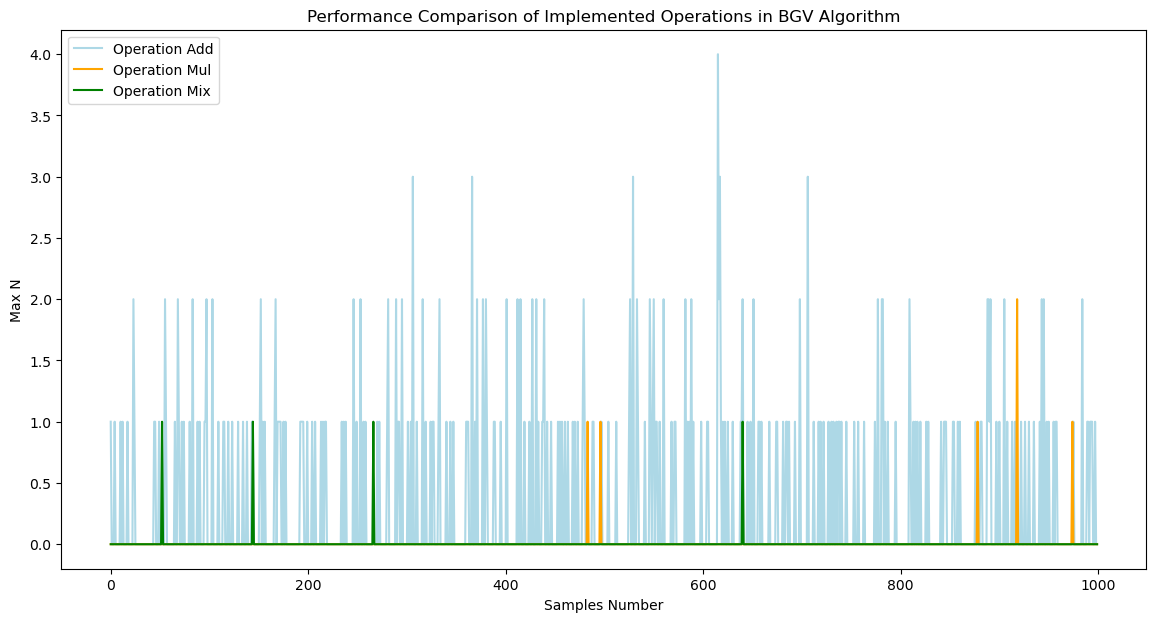

In [569]:
plt.figure(figsize=(14, 7))
plt.plot([i for i in range(1000)], results_test_add, c = 'lightblue', label ='Operation Add')
plt.plot([i for i in range(1000)], results_test_mul, c = 'orange', label = 'Operation Mul')
plt.plot([i for i in range(1000)], results_test_mix, c = 'green', label = 'Operation Mix')
plt.xlabel('Samples Number')
plt.ylabel('Max N')
plt.legend(loc='upper left')
plt.title('Performance Comparison of Implemented Operations in BGV Algorithm')
plt.show()

### Opis rezultatów



Dla przeprowadzonych testów uzyskano następujące rezultaty:

1. Program mógł wykonać maksymalnie N = 4 operacji dodawania zanim narastające błędy spowodowały błędne deszyfrowanie. Obserując wykres można stwierdzić, że dla jednej operacji dodawania wynik jest przeważnie poprawny. W przypadku dwóch operacji dodawania częściej występują błędy. Patrząc od 3 operacji wzwyż można stwierdzić, że narastające błędy skutkują praktycznie brakiem poprawnych wyników.

2. Program mógł wykonać maksymalnie N = 2 operacji mnożenia zanim narastające błędy spowodowały błędne deszyfrowanie. Obserwujac wykres można stwierdzić, że bardzo rzadko operacje mnożenia dawały poprawne rezultaty. Jeśli już wynik był pozytywny to przeważnie był on wynikiem jednej operacji mnożenia.

3. Program mógł wykonać maksymalnie N = 1 operację mieszaną zanim narastające błędy spowodowały błędne deszyfrowanie. Nie jest to zaskakujący rezultat biorąc pod uwagę słabe wyniki operacji mnożenia, które wpływają na wyniki operacji mieszanej. Operacje mieszane bardzo rzadko dawały poprawne rezultaty. Jeśli już wynik był pozytywny to przeważnie był on wynikiem jednej operacji mieszanej.